# BASIC CONTROLLERS

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

This notebook describes the proportional, integral, and differential controllers.

# Preliminaries

In [1]:
!pip install -q control
!pip install -q tellurium
#!pip install -q controlSBML==0.2.14
!pip install -q controlSBML

import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

     |████████████████████████████████| 357 kB 5.1 MB/s 
     |████████████████████████████████| 121 kB 8.4 MB/s 
     |████████████████████████████████| 3.3 MB 49.7 MB/s 
     |████████████████████████████████| 38.1 MB 301 kB/s 
     |████████████████████████████████| 2.6 MB 41.2 MB/s 
     |████████████████████████████████| 5.0 MB 46.7 MB/s 
     |████████████████████████████████| 5.6 MB 17.4 MB/s 
     |████████████████████████████████| 6.8 MB 34.5 MB/s 
     |████████████████████████████████| 36.7 MB 1.3 MB/s 
     |████████████████████████████████| 3.2 MB 55.3 MB/s 
     |████████████████████████████████| 2.1 MB 40.0 MB/s 
     |████████████████████████████████| 54.8 MB 1.3 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
     |███████████████████████

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

# Antimony Model

In [3]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

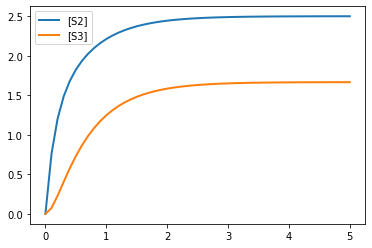

In [4]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 1
k2 = 2
k3 = 3
k4 = 4
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL)
RR.simulate()
RR.plot()

# PID Controllers

The controllers considered here are systems that input the control error and produce a control signal used
to regulate the system under control.
The input signal is $e(t)$ and the output signal is $u(t)$.

A **proportional controller** has the parameter $k_P$.
This controller outputs a signal that is proportional to the control error.
That is, $u(t) = k_P e(t)$.
The transfer function for this controller is $H_{P} (s) = k_p$.

An **integral controller** has the parameter $k_I$.
This controller outputs a signal that is proportional to the *integral* of the control error.
That is, $u(t) = k_I \int_0^{t} e(\tau) d \tau$.
The transfer function for this controller is $H_{I} (s) = \frac{k_I}{s}$.

An **differential controller** has the parameter $k_D$.
This controller outputs a signal that is proportional to the derivative of the control error.
That is, $u(t) = k_D \frac{de(t)}{d t}$.
The transfer function for this controller is $H_{D} (s) = s k_D$.

These controllers can be used in combination.
For example, a PI controller produces 
$u(t) = k_P e(t) +  k_I \int_0^{t} e(\tau) d \tau + k_D \frac{d e(t)}{d t}$,
and its transfer function is $H_{CPI}(s) = k_P + \frac{k_I}{s} + s k_D$.

# Analysis in Discrete Time

To improve our understanding of the different types of control, we'll do an analysis in discrete time.
Let $n$ index the instances.
Consider an input signal $e_n$ and an output signal $u_n$. Here's how the controllers work:
* **Proportional control**. $u_n = k_P  e_n$
* **Integral control**. $u_n = k_I  \sum_{i=0}^n e_i$
* **Differential control**. $u_n = k_D (e_n - e_{n-1})$

Now let's create an envaluation environment.

## Analysis Codes

In [5]:
def evaluateController(e_vec, kp=0, ki=0, kd=0, is_plot=True, **kwargs):
    """
    Plots the output of the controller for the signal.
    
    Parameters
    ----------
    e_vec: list-float
    kp: float
    ki: float
    kd: float
    is_plot: bool
    kwargs: dict
        plot options
    
    Returns
    -------
    np.array
    """
    u_vec = []
    e_last = e_vec[0]
    e_sum = e_vec[0]
    for e_val in e_vec[1:]:
        e_sum  += e_val
        #
        u_val = kp*e_val
        u_val += ki*e_sum
        u_val += kd*(e_val - e_last)
        u_vec.append(u_val)
        #
        e_last = e_val
    #
    if is_plot:
        times = range(len(u_vec))
        y_vec = e_vec[0:len(times)]
        df = pd.DataFrame({
            "time": times,
            "e(t)": e_vec[0:len(times)],
            "u(t)": u_vec
        })
        ts = ctl.Timeseries(df)
        title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
        kwargs["title"] = title
        ctl.plotOneTS(ts, **kwargs)
        if False:
            if ax is None:
                _, ax = plt.subplots(1)
            ax.plot(range(len(u_vec)), u_vec, color="blue")

            ax.plot(times, y_vec, linestyle="--", color="black")
            ax.legend(["u(t)", "e(t)"])
            ax.set_xlabel("time")
            ax.set_ylim([-1.5, 1.5])
            title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
            ax.set_title(title)
    return np.array(u_vec)
             
# Tests
e_vec = np.repeat(1, 10)
u_vec = evaluateController(e_vec, kp=0, ki=0, kd=1, is_plot=False)
assert(u_vec[0] == 0)
print("OK!")

OK!


## Analysis

What signals should we consider for $e(t)$?

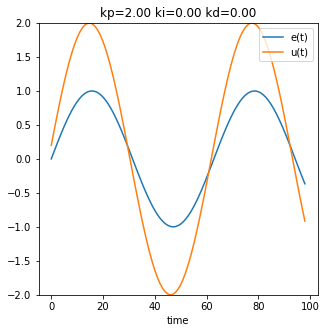

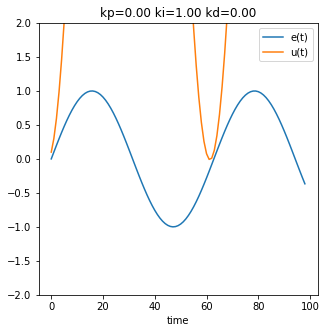

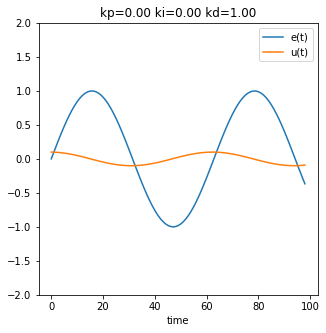

In [6]:
step_input = np.repeat(1, 10)
step_input = np.sin(0.1*np.array(range(100)))
_ = evaluateController(step_input, kp=2, ylim=[-2,2], figsize=(5,5))
_ = evaluateController(step_input, ki=1, ylim=[-2,2], figsize=(5,5))
_ = evaluateController(step_input, kd=1, ylim=[-2,2], figsize=(5,5))

# Analysis in Continuous Time

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

We can analyze controllers by looking at their transfer functions by considering poles, DC gain, and step respoinse.

$H_{PID} (s) = H_P(s) + H_I(s) + H_D(s) =  k_P + \frac{k_I}{s} + s k_D$

## Analysis Codes

In [7]:
def plotPIDStepResponse(kp=1, ki=0, kd=0, is_plot=True):
    """
    Plots the step response of the PID controller.
    
    Parameters
    ----------
    kp: float
    ki: float
    kd: float
    is_plot: bool
    
    Returns
    -------
    control.TransferFunction
    """
    tf = control.TransferFunction([kp], [1])  \
          + control.TransferFunction([ki], [1, 0])  \
          + control.TransferFunction([kd, 0], [1])
    if is_plot:
        if len(tf.num[0][0]) > len(tf.den[0][0]):
            print("Improper transfer function. Cannot simulate.")
        else:
            result = control.step_response(tf)
            plt.plot(result.t.flatten(), result.y.flatten())
    return tf

# Tests
tf = plotPIDStepResponse(kp=1, ki=0, kd=0, is_plot=False)
assert(tf.dcgain() == 1)
print("OK!")

OK!


In [8]:
# Find the DC gains for different variations of controllers
print("kp=1: %2.2f" % plotPIDStepResponse(kp=1, ki=0, kd=0, is_plot=False).dcgain())
print("ki=1: %2.2f" % plotPIDStepResponse(kp=0, ki=1, kd=0, is_plot=False).dcgain())

kp=1: 1.00
ki=1: inf


## Controller in Closed Loop

### Extending ``plotTF`` to PID Controllers

In [9]:
def plotTFs(Gs, kp=0, ki=0, kd=0, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    kp: float
    ki: float
    kd: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([kp], [1]) + control.TransferFunction([ki], [1, 0])  \
        + control.TransferFunction([kd, 0], [1])
    Fs = 1
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=times, U=1)
        plt.plot(result.t.flatten(), result.y.flatten())
    # Refine plots
    plt.legend(list(tf_dct.keys()))
    xmax = max(result.t.flatten())
    plt.plot([0, xmax], [0, 0], linestyle="--", color="black")
    plt.plot([0, xmax], [1, 1], linestyle="--", color="grey")
    plt.ylim([-5, 5])
    title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
    plt.title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, kp=10, ylim=[0, 3], title="Example", is_plot=False)
assert(len(dct) == 4)
assert("TransferFunction" in str(type(dct["HRYs"])))
print("OK!")

OK!


In [10]:
dct["HRYs"]

TransferFunction(array([20., 60.]), array([ 1., 26., 69.]))

### Plots

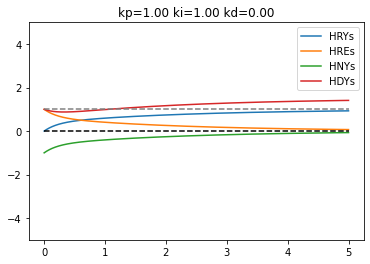

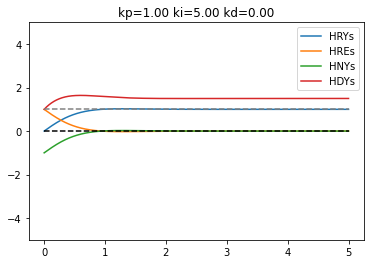

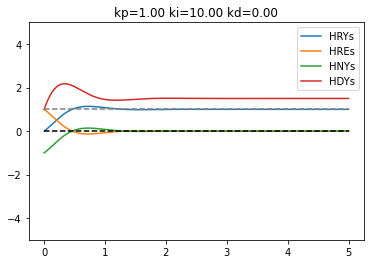

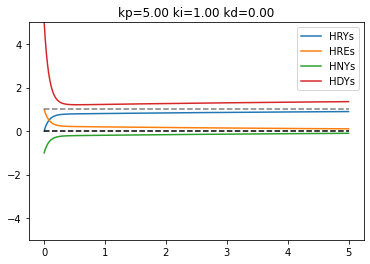

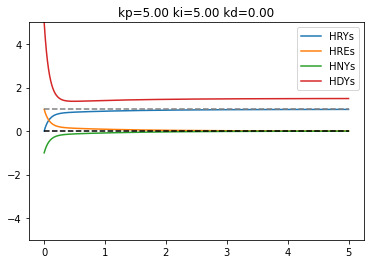

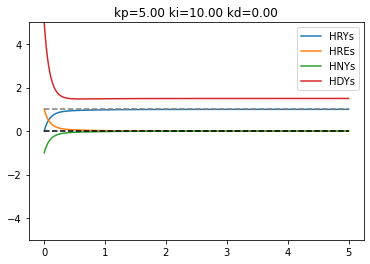

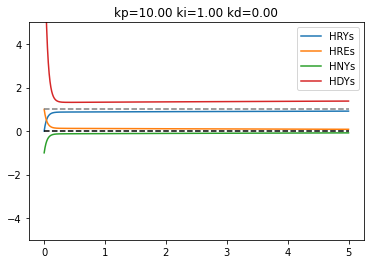

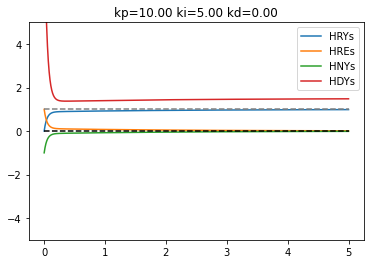

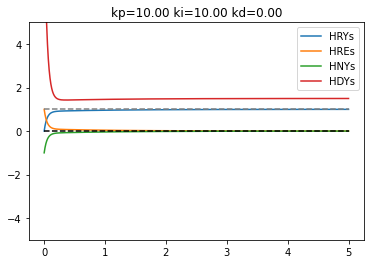

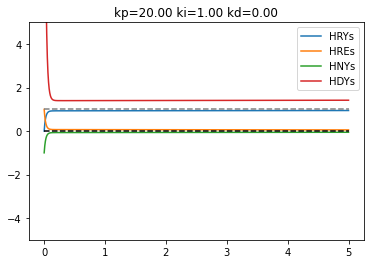

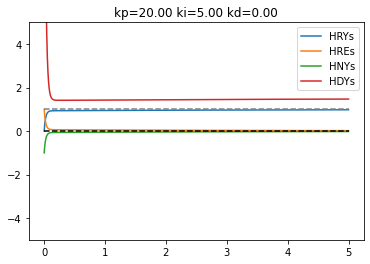

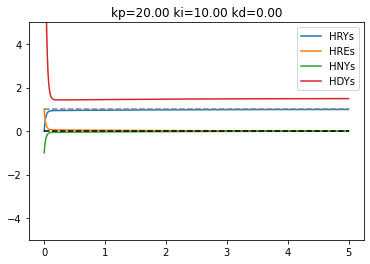

In [11]:
for kp in [1, 5, 10, 20]:
    for ki in [1, 5, 10]:
        title = "kp: %2.1f ki: %2.1f" % (kp, ki)
        _ = plotTFs(Gs, kp=kp, ki=ki, title=title, ylim=[-1, 3])

# Testbed

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

## Controller Factory

**We need to extend ``makeController`` to PID**

$\dot{\bf x} = {\bf f} ({\bf x}, {\bf u})$

In [12]:
# Extend to PID
def makeController(name, kp=0, ki=0, kd=0):
    """
    Creates a proportional controller as a NonlinearIOSystem with input "in" and output "out".
    
    Parameters
    ----------
    name: str
        Name of the system
    kp: float
    ki: float
    kd: float
    
    Returns
    -------
    control.NonlinearIOSystem
    """
    def updfcn(time, x_vec, u_vec, params):
        """
        Calculates the derivative of state.
        
        Parameters
        ----------
        x_vec: array of dimension 2
            0: last time
            1: last input
            2: sum of input values
        u_vec: error signal input
        
        Returns
        -------
        dtime: float
            derivative of time
        dinput: float
            derivative of input
        dsum: float
            derivative of sum
        """
        try:
            u_val = u_vec[0]
        except:
            u_val = u_vec
        #
        dtime = time - x_vec[0]
        if np.isclose(dtime, 0):
            dinput = 0
            dsum = 0
        else:
            dinput = (u_val - x_vec[1])/dtime
            dsum = u_val/dtime
        return dtime, dinput, dsum
        
    def outfcn(_, x_vec, u_val, ___):
        # u: float (error signal)
        try:
            u_val = u_vec[0]
        except:
            u_val = u_vec
        return kp*(u_val) + ki*x_vec[2] + kd*(u_val - x_vec[1])
    #
    return control.NonlinearIOSystem(
        updfcn, outfcn, inputs=['in'], outputs=['out'], states=["dtime", "dinput", "dsum"],
        name=name)

# Tests
controller = makeController("controller", kp=1, ki=1, kd=1)
times = ctl.makeSimulationTimes()
U = np.repeat(1, len(times))
U[0] = 1
result = control.input_output_response(controller, T=times, U=U)
#trues = [r == kp*( t) for t, r in zip(result.t, result.outputs)]
#assert(all(trues))
print("OK!")

OK!


## Closed Loop System

In [24]:
# Elements of the system

factory = ctl.IOSystemFactory()
kp = 1
ki = 1
kd = 0
# Create the elements of the feedback loop
noise = factory.makeSinusoid("noise", 0, 20)
disturbance = factory.makeSinusoid("disturbance", 0, 2)

ctlsb = ctl.ControlSBML(MODEL, input_names=["S2"], output_names=["S3"])
system = ctlsb.makeNonlinearIOSystem("system")
controller = factory.makePIDController("controller", kp=kp, ki=ki, kd=kd)
fltr = factory.makePassthru("fltr")

sum_Y_N = factory.makeAdder("sum_Y_N")
sum_U_D = factory.makeAdder("sum_U_D")
sum_R_F = factory.makeAdder("sum_R_F")

In [25]:
# Create the closed loop system
closed_loop = control.interconnect(
  [noise, disturbance, sum_Y_N, sum_R_F, sum_U_D, system, fltr, controller ], 
  connections=[
    ['controller.in', 'sum_R_F.out'],    # e(t)
    ['sum_U_D.in1', 'controller.out'],   # u(t)
    ['sum_U_D.in2', 'disturbance.out'],  # d(t)
    ['system.S2',   'sum_U_D.out'],
    ['sum_Y_N.in1', 'system.S3'],        # y(t)
    ['sum_Y_N.in2', 'noise.out'],        # n(t)
    ['fltr.in',     'sum_Y_N.out'],
    ['sum_R_F.in1', '-fltr.out'],
  ],
  inplist=["sum_R_F.in2"],
  outlist=["sum_R_F.in2", "sum_Y_N.out", 'system.S2', 'system.S3'],
)

## Plots

We can use the transfer functions to guide our choice of parameters.
Note that we it may be necessary to divide by $s$ to calculate the DC gain.

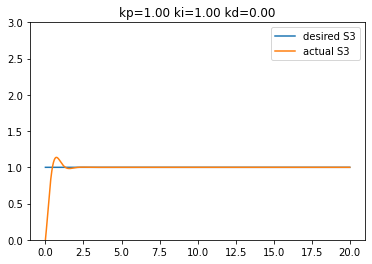

In [26]:
times = ctl.makeSimulationTimes(0, 20, 100)
result = control.input_output_response(closed_loop, T=times, U=1)
plt.plot(result.t, result.outputs[0].flatten())
plt.plot(result.t, result.outputs[1].flatten())
#plt.plot(result.t, result.outputs[2].flatten())
#plt.plot(result.t, result.outputs[3].flatten())
plt.ylim([0, 3])
legends = ["desired S3", "actual S3"]
title = "kp=%2.2f ki=%2.2f kd=%2.2f" % (kp, ki, kd)
plt.title(title)
plt.legend(legends)

## Transfer Function Analysis

In [16]:
result = control.forced_response(Gs, T=ctl.makeSimulationTimes(), U=1)
result.y

array([[0.        , 0.17278785, 0.30079224, 0.39562023, 0.46587053,
        0.51791323, 0.55646741, 0.58502905, 0.60618803, 0.62186299,
        0.63347529, 0.64207789, 0.64845085, 0.65317206, 0.65666962,
        0.65926067, 0.66118017, 0.66260217, 0.66365561, 0.66443602,
        0.66501417, 0.66544246, 0.66575975, 0.66599481, 0.66616894,
        0.66629794, 0.66639351, 0.66646431, 0.66651676, 0.66655561,
        0.66658439, 0.66660572, 0.66662151, 0.66663322, 0.66664189,
        0.66664831, 0.66665307, 0.66665659, 0.6666592 , 0.66666114,
        0.66666257, 0.66666363, 0.66666442, 0.666665  , 0.66666543,
        0.66666575, 0.66666599, 0.66666617, 0.6666663 , 0.66666639,
        0.66666646]])

1 1 5


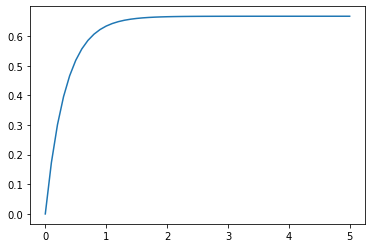

In [17]:
# Linearized analysis
print(kp, ki, kd)
Gs = ctlsb.makeTransferFunction()
result = control.forced_response(Gs, T=ctl.makeSimulationTimes(), U=1)
plt.plot(result.t.flatten(), result.y.flatten())

## Evaluation Environment

We want to repeatedly evaluate different controller parameters.
This is cumbersome to do if we have to rerun multiple cells and reset various parameters.
It's much more efficient to create an evaluation function.

In [18]:
def runTestbed(model=MODEL, input_name="S2", output_name="S3", kp=0, ki=0, kd=0, noise_amp=0, disturbance_amp=0):
    """
    Run the testbed and plot the results.
    
    Parameters
    ----------
    model: str
        System under control
    input_name: str
    output_name: str
    kp: float
    ki: float
    kd: float
    noise_amp: float
    disturbance_amp: float
    
    Results
    -------
    control.InterconnectedSystem
    """

In [19]:
def makeHRY(model=MODEL, input_name="S2", output_name="S3", time=0, kp=0, ki=0, kd=0):
    """
    Calculates the transfer function from the reference input to the output.
    
    Parameters
    ----------
    model: str
    input_name: str
    output_name: str
    time: float
    kp: float
    ki: float
    kd: float
    
    Returns
    -------
    control.TransferFunction
    """
    ctlsb = ctl.ControlSBML(MODEL, input_names=[input_name], output_names=[output_name])
    Gs = ctlsb.makeTransferFunction(time=time)
    dct = plotTFs(Gs, kp=kp, ki=ki, kd=kd, is_plot=False)
    return dct["HRYs"]
    
    
# TESTS
tf = makeHRY()
assert(tf.dcgain() == 0)

In [20]:
makeHRY(kp=10, ki= 100, time=1).pole()

array([-11.5+8.23103882j, -11.5-8.23103882j,  -3. +0.j        ,
         0. +0.j        ])

# More On Filters

How do filters help with sinusoidal noise and disturbances?

In [21]:
# Create a testsbed
factory = ctl.IOSystemFactory()
fltr = factory.makeFilter("fltr", -50)
noise = factory.makeSinusoid("noise", 1, 20)

In [22]:
# Create the testbed
test_bed = control.interconnect(
  [noise, fltr ], 
  connections=[
    ['fltr.in', 'noise.out'],    # e(t)
    
  ],
  outlist=["fltr.out"],
)

(-1.0, 1.0)

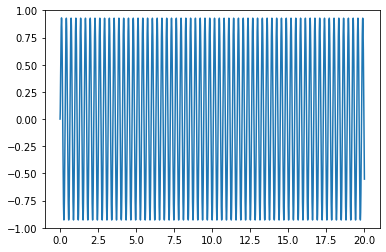

In [23]:
# Simulate it
times = ctl.makeSimulationTimes(0, 20, 500)
result = control.input_output_response(test_bed, T=times)
plt.plot(result.t, result.outputs.flatten())
plt.ylim([-1, 1])